[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Segmentation-Background Removal-1

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
  1. Broccoli-08/SEP/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * eden_library_notebooks/
       * image_preprocessing/
          * plant_segmentation-background_removal-1.ipynb
       * eden_data/
          * Broccoli-080919-Healthy-zz-V1-20210225102111
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_transfer_learning.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply you as soon as possible.

## Background (Go to [Biobliography](#references) for more details)

In order to improve the performance of a deep-learning-based system, many times a pre-processing step known as background removal is applied. This technique is supposed to remove as much noise/background from the image, making the object of study appearing as the main part of the picture. Additionally, background removal is not only useful for improving the performance of the deep neural network, but also for reducing <a href="https://en.wikipedia.org/wiki/Overfitting">overfitting</a>.

In **agriculture**, several works have made use of background removal techniques for achieving a better performance (**Mohanty et al., 2016; McCool et al., 2017; Milioto et al., 2017; Espejo-Garcia et al., 2020**).

In this notebook, we are gonna cover one of the most important pre-processing steps when implementing an AI-based solution in weeds identification: **Background removal**. Specifically, the GrabCut algorithm is gonna be used. Designed in Rother et al., 2004, this is an algorithm for foreground extraction with minimal user interaction. The algorithm works like this:

1. User inputs a rectangle and every pixel outside this rectangle will be taken as sure background. On the other hand,  everything inside rectangle is unknown. The inputs won't change in the process.
2. A Gaussian Mixture Model (GMM) is used to model the foreground and background pixel distribution.
3. The unknown pixels are labelled either probable foreground or probable background depending on its relation with the other previously labelled pixels (step 1) in terms of color statistics.
4. A graph is built from this pixel distribution. Nodes in the graphs are pixels. Additional two nodes are added, Source node and Sink node. Every foreground pixel is connected to Source node and every background pixel is connected to Sink node.
5. The weights of edges connecting pixels are defined by the probability of a pixel being foreground/background. The weights between the pixels are defined by the edge information or pixel similarity. For instance, if there is a large difference in pixel color, the edge between them will get a low weight.
6. Afterwards, a mincut algorithm is used to segment the graph. After the cut, all the pixels connected to Source node become foreground and those connected to Sink node become background.
7. The algorithm will continue until the classification converges.

**UPDATES**

*  ***28/04/2021*** Changed the file structure, see instructions for details. ( **IMPORTANT** )
*  ***28/04/2021*** Upgraded read function to become OS agnostic. It now works for both Windows and Linux machines.

#### Library Imports

In [19]:
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
from pathlib import Path

import random
import matplotlib.pyplot as plt

%matplotlib inline

#### Auxiliar Functions

In [20]:
# Reads data from the specified paths in path_list
def read_data(path_list, im_size=(128,128)):
    
    X = []
    
    for path in path_list :
        for im_file in tqdm(glob(path + '*/*')):
            if im_file.lower().endswith("jpg"): # Avoid reading metadata .txt files.
                try:
                    im = cv2.imread(im_file)
                    # Resize to appropriate dimensions.You can try different interpolation methods.
                    im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
                    # By default OpenCV read with BGR format, return back to RGB.
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                    X.append(im)
                except Exception as e:
                    # In case annotations or metadata are found
                    print("Not a picture")
    
    X = np.array(X)# Convert list to numpy array.
    
    return X

In [21]:
def plot_sample(images):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images[random.randint(0, images.shape[0]-1)])

#### Experimental Constants

In [22]:
NUM_ITERS = 5
IM_SIZE = (256, 256)
# Datasets' paths we want to work on.
PATH_LIST = ['eden_data/Broccoli-080919-Healthy-zz-V1-20210225102111']

#### Reading and showing pictures

In [23]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 93/93 [00:12<00:00,  7.54it/s]


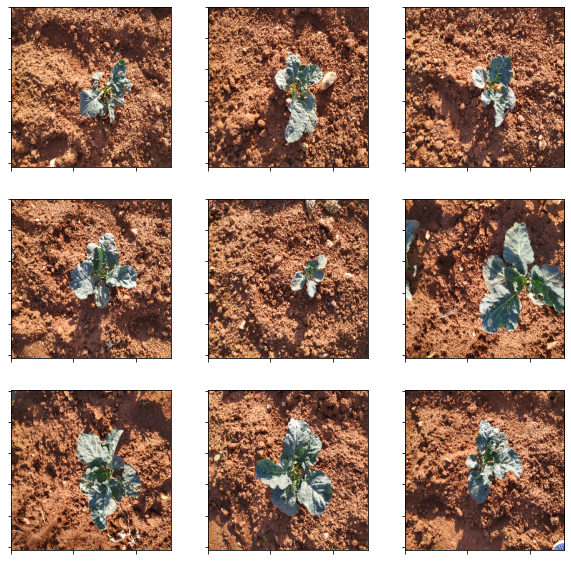

In [24]:
plot_sample(X)

#### Grabcut Algorithm for background removal

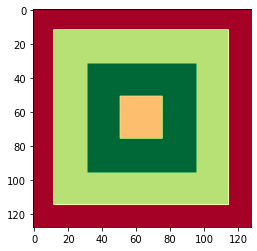

In [25]:
def add_contours(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) != 0:
        cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0) ,2)
    
def remove_background(image):
    h, w = image.shape[:2]
    mask = init_grabcut_mask(h, w)
    bgm = np.zeros((1, 65), np.float64)
    fgm = np.zeros((1, 65), np.float64)
    # We give the rectangle parameters and let the algorithm run for NUM_ITERS iterations. 
    # The parameter mode should be cv.GC_INIT_WITH_RECT since we are using rectangle. 
    cv2.grabCut(image, mask, None, bgm, fgm, NUM_ITERS, cv2.GC_INIT_WITH_MASK)
    mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = cv2.bitwise_and(image, image, mask = mask_binary)
    add_contours(result, mask_binary) # optional, adds visualizations
    
    return result

def init_grabcut_mask(h, w):
    mask = np.ones((h, w), np.uint8) * cv2.GC_BGD # A trivial background pixel
    mask[h//10:9*h//10, w//10:9*w//10] = cv2.GC_PR_BGD # A possible backgroung pixel
    mask[h//4:3*h//4, w//4:3*w//4] = cv2.GC_PR_FGD # A possible foreground pixel
    mask[2*h//5:3*h//5, 2*w//5:3*w//5] = cv2.GC_FGD # A trivial foreground pixel
    
    return mask

plt.imshow(init_grabcut_mask(128, 128), cmap="RdYlGn")

#### Executing algorithm

In [26]:
%%time
filtered_images = []
for im in X:
    filtered_images.append(remove_background(im))

Wall time: 19.3 s


#### Displaying the results

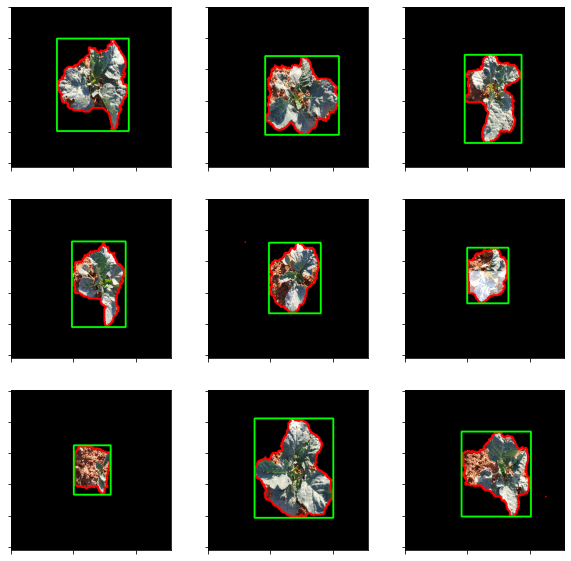

In [27]:
plot_sample(np.array(filtered_images))

## Possible Extensions
1. Change the number of iterations used by the algorithm (5 in this notebook)
2. Use other dataset from the <a href="https://edenlibrary.ai">Eden platform</a>

## Bibliography
<a id='references'></a>
Rother, C., Kolmogorov, V., & Blake, A. (2004). "GrabCut": interactive foreground extraction using iterated graph cuts. ACM SIGGRAPH 2004 Papers.

McCool, C., Perez, T., Upcroft, B., 2017. Mixtures of lightweight deep convolutional neural networks: applied to agricultural robotics. IEEE Rob. Autom. Lett. 2 (3), 1344–1351.

Milioto, A., Lottes, P., Stachniss, C., 2017. Real-time blob-wise sugar beets vs weeds classification for monitoring fields using convolutional neural networks. Proceedings of the International Conference on Unmanned Aerial Vehicles in Geomatics. Bonn, Germany.

Mohanty, S.P., Hughes, D.P., Salathé, M., 2016. Using deep learning for image-based plant disease detection. Front. Plant. Sci. 7.

Espejo-García, B., Mylonas, N., Athanasakos, L., Fountas, S., & Vasilakoglou, I. (2020). Towards weeds identification assistance through transfer learning. Comput. Electron. Agric., 171, 105306.

OpenCV details: https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

## Acknowledgements
This notebook was highly inspired by Victor-Louis De Gusseme (https://www.kaggle.com/victorlouisdg/plant-pathology-opencv-background-removal)